In [1]:
# This noteboook is based on:
# https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier
# Thank you!

In [75]:
try:
    try:
        print('Before')
        # raise NameError('name1')
        print('After')
        raise ZeroDivisionError('zero1')
    finally:
        pass
        print('Finally')
        # raise NameError('name2')
        # raise ZeroDivisionError('zero2')
# except (NameError, ZeroDivisionError) as e:
except NameError as e:
    print('1')
    print(e)
# except Exception as f:
#    print('2')
#    print(f)

Before
After
Finally


ZeroDivisionError: zero1

In [2]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 30

### Load dataset info

In [4]:
path_to_train = '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/train/'
data = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [5]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.25, random_state=42)

### Create datagenerator

In [6]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        # Modified: image channels.
        # image = np.stack((
        #    R/2 + Y/2, 
        #    G/2 + Y/2, 
        #    B),-1)
        image = np.stack((
        R * 2 / 3 + G / 3,
        B * 2 / 3 + G / 3,
        Y * 2 / 3 + G / 3), -1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [7]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 0.6648585834858931


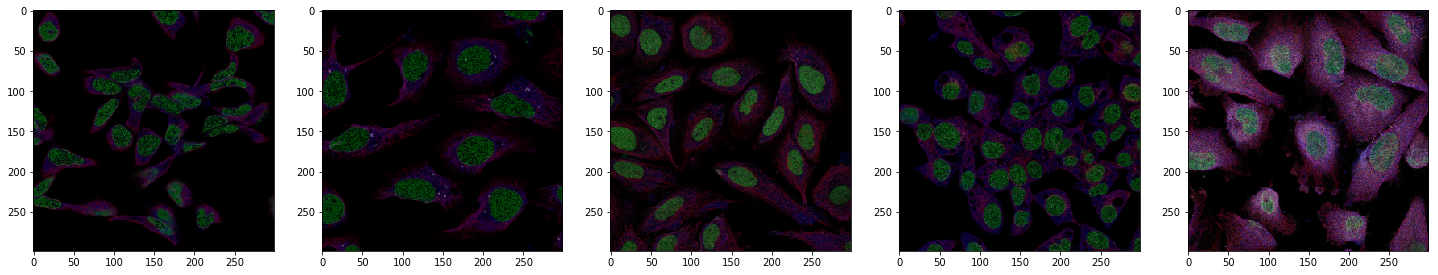

In [8]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

threshold = 0.2

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [10]:
# Modified. Reference: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
def macro_f1_with_thres(threshold):
    def f1(y_true, y_pred):
            y_true = K.cast(y_true, 'float')
            y_pred = K.cast(K.greater(K.cast(y_pred, 'float'), threshold), 'float')
    
            tp = K.sum(y_true * y_pred, axis=0)
            fp = K.sum((1-y_true)*y_pred, axis=0)
            fn = K.sum(y_true*(1-y_pred), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
            return K.mean(f1)
    return f1

In [11]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [12]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
__________

### Train model

In [13]:
checkpointer = ModelCheckpoint(
    '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False) # not Modified
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False # not Modified

# Changed from binary CE to categorical CE.
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-3),
    # metrics=['acc', f1])
    metrics=['acc', macro_f1_with_thres(threshold)])
    
history = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/15
30/30 [==============================] - 1589s 53s/step - loss: 4.8854 - acc: 0.3144 - f1: 0.0972 - val_loss: 4.9013 - val_acc: 0.2539 - val_f1: 0.0907

Epoch 00001: val_loss improved from inf to 4.90131, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 2/15
30/30 [==============================] - 1634s 54s/step - loss: 4.5560 - acc: 0.3767 - f1: 0.0959 - val_loss: 4.5571 - val_acc: 0.3750 - val_f1: 0.0845

Epoch 00002: val_loss improved from 4.90131 to 4.55710, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 3/15
30/30 [==============================] - 1526s 51s/step - loss: 4.5090 - acc: 0.4078 - f1: 0.0964 - val_loss: 4.6985 - val_acc: 0.3789 - val_f1: 0.0825

Epoch 00003: val_loss did not improve from 4.55710
Epoch 4/15
30/30 [==============================] - 1710s 57s/step - loss: 

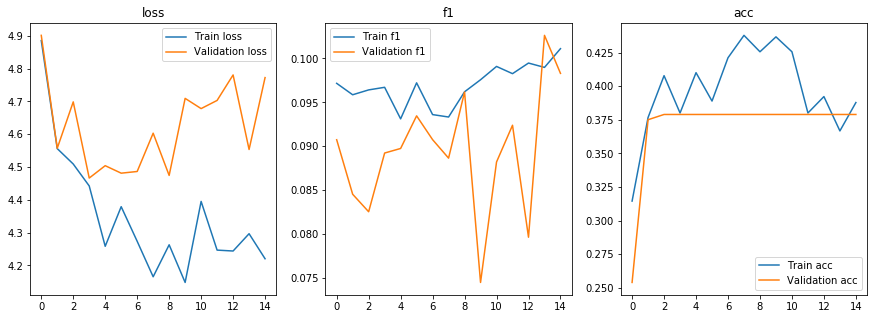

In [14]:
show_history(history)

In [16]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

# Changed from binary CE to Categorical CE
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-4),
    # metrics=['acc', f1])
    metrics = ['acc', macro_f1_with_thres(threshold)])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    validation_data=next(validation_generator),
    epochs=20, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/20
30/30 [==============================] - 2104s 70s/step - loss: 4.1625 - acc: 0.3867 - f1: 0.1031 - val_loss: 3.8249 - val_acc: 0.3711 - val_f1: 0.0880

Epoch 00001: val_loss improved from 3.89712 to 3.82488, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 2/20
30/30 [==============================] - 2310s 77s/step - loss: 4.0899 - acc: 0.4167 - f1: 0.1043 - val_loss: 3.7601 - val_acc: 0.3711 - val_f1: 0.0944

Epoch 00002: val_loss improved from 3.82488 to 3.76011, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 3/20
30/30 [==============================] - 2019s 67s/step - loss: 4.2625 - acc: 0.4300 - f1: 0.1019 - val_loss: 3.7882 - val_acc: 0.3711 - val_f1: 0.1016

Epoch 00003: val_loss did not improve from 3.76011
Epoch 4/20
30/30 [==============================] - 2017s 67s/step - lo

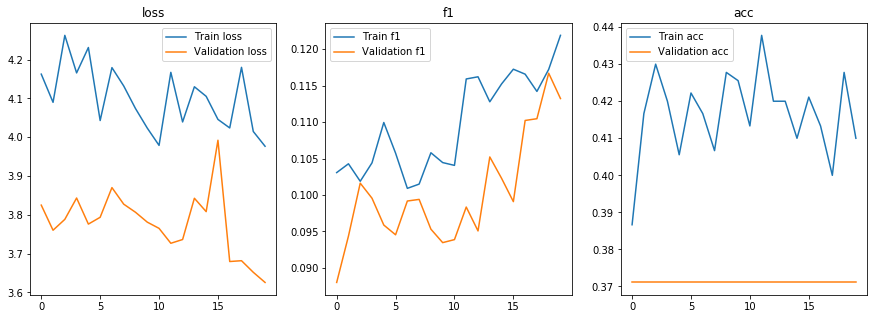

In [17]:
show_history(history)

### Create submit

In [18]:
model = load_model(
    '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model', 
    custom_objects={'f1': macro_f1_with_thres(threshold)})

In [19]:
submit = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')

In [21]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=threshold]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [1:58:41<00:00,  1.79it/s] 

CPU times: user 5h 43min 7s, sys: 33min 47s, total: 6h 16min 55s
Wall time: 1h 58min 41s


In [22]:
submit['Predicted'] = predicted
submit.to_csv('submission_1_2.csv', index=False)

In [23]:
%%time
submit_05 = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')
submit_1 = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')
submit_15 = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')
submit_3 = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')

predicted_05 = []
predicted_1 = []
predicted_15 = []
predicted_3 = []

for name in tqdm(submit_05['Id']):
    path = os.path.join('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict_05 = np.arange(28)[score_predict>=0.05]
    label_predict_1 = np.arange(28)[score_predict>=0.1]
    label_predict_15 = np.arange(28)[score_predict>=0.15]
    label_predict_3 = np.arange(28)[score_predict>=0.3]
    
    str_predict_label_05 = ' '.join(str(l) for l in label_predict_05)
    str_predict_label_1 = ' '.join(str(l) for l in label_predict_1)
    str_predict_label_15 = ' '.join(str(l) for l in label_predict_15)
    str_predict_label_3 = ' '.join(str(l) for l in label_predict_3)
                
    predicted_05.append(str_predict_label_05)
    predicted_1.append(str_predict_label_1)
    predicted_15.append(str_predict_label_15)
    predicted_3.append(str_predict_label_3)
    
submit_05['Predicted'] = predicted_05
submit_1['Predicted'] = predicted_1
submit_15['Predicted'] = predicted_15
submit_3['Predicted'] = predicted_3

submit_05.to_csv('submission_1_05.csv', index=False)
submit_1.to_csv('submission_1_1.csv', index=False)
submit_15.to_csv('submission_1_15.csv', index=False)
submit_3.to_csv('submission_1_3.csv', index=False)

100%|██████████| 11702/11702 [1:48:37<00:00,  1.79it/s]

CPU times: user 5h 33min 35s, sys: 31min 48s, total: 6h 5min 24s
Wall time: 1h 48min 37s


In [ ]:
# Create download link, in case we cannot see the generated file before submitting.
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
# df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
df = submit

# create a link to download the dataframe
create_download_link(df)